
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [29]:
import autograd.numpy as np 
import matplotlib.pyplot as plt
from fgbuster import CMB, Dust, Synchrotron, MixingMatrix
from fgbuster.observation_helpers import standardize_instrument, get_observation
from fgbuster.cosmology import _get_Cl_cmb, _get_Cl_noise
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import healpy as hp
import numdifftools.core as nd
import math as m
from fgbuster.algebra import  W_dBdB, W_dB, W, _mmm, _utmv, _mmv, comp_sep
import pylab as pl

## 1.general parameters

In [30]:
nside = 64
model = 'd0s0'

Load the instrument

In [31]:
instr = np.load('/Users/alicepirotta/Desktop/APC/MCMC/instrument_LB_IMOv1.npy', allow_pickle=True).item()
instr_ = {}
instr_['frequency'] = np.array([instr[f]['freq'] for f in instr.keys()])
instr_['depth_p'] = np.array([instr[f]['P_sens'] for f in instr.keys()])
instr_['fwhm'] = np.array([instr[f]['beam'] for f in instr.keys()])
instr_['depth_i'] = instr_['depth_p']/np.sqrt(2)
instrument = standardize_instrument(instr_)

Get the frequency maps 

In [32]:
d_fgs_N = get_observation(instrument, model, noise=True, nside=nside)
d_fgs = get_observation(instrument, model, noise=False, nside=nside)

#take only the Q and U, not I
freq_maps_N= d_fgs_N[:,1:,:]
freq_maps= d_fgs[:,1:,:]

n_freqs = freq_maps.shape[0]
n_stokes = freq_maps.shape[1]
n_pix = freq_maps.shape[2]

Chose the components to fit for

In [33]:
components= [CMB(), Dust(150.), Synchrotron(150.)]

In [34]:
M = MixingMatrix(*components) 
M_ev = M.evaluator(instrument.frequency)

Define the noise covariance matrix

In [35]:
N = np.diag((instrument.depth_p / hp.nside2resol(nside, arcmin=True))**2)
invN = np.linalg.inv(N)

## 2.component separation

true and initial values for the parameters

In [36]:
gains_true = np.ones(21)
x_true = np.concatenate((M.defaults, gains_true))
x_init = np.random.uniform(low=x_true * (1 - 1 / 40), high= x_true * (1 + 1 / 40))

#### average spectral likelihood

In [37]:

dati = np.einsum('abc,cbx-> ax',freq_maps,freq_maps.T)


def aver_likelihood(y):
    Bd, T, Bs, a, b, c, d, e, f, g, i, l, m, n, o, p, q, r, s, t, u, v, w, z = y
    h = 1
    G = np.diag([a, b, c, d, e, f, g, h, i, l, m, n, o, p, q, r, s, t, u, v, w, z ])
    A =G.dot(M_ev(np.array([Bd,T,Bs]))) 
    logL=0
    NA= np.einsum('ab,bc->ac', invN,A)
    AtNA = np.linalg.inv(np.einsum('ab,bc,cd->ad',A.T,invN,A))
    AtN= np.einsum('ab,bc->ac', A.T, invN)
    P = np.einsum ('ab,bc,cd->ad',NA,AtNA,AtN)
    dN = dati+N
    logL = logL - np.trace(np.einsum('ab,bc->ac',P,dN))/2
    if logL != logL:
        return 0.0
    return logL

In [38]:

# def spectral_likelihood(y):
#     Bd, T, Bs, a, b, c, d, e, f, g, i, l, m, n, o, p, q, r, s, t, u, v, w, z = y
#     h= 1
#     G = np.diag([a, b, c, d, e, f, g, h, i, l, m, n, o, p, q, r, s, t, u, v, w, z])
#     invNd = np.einsum('ij,jsp->isp', invN, freq_maps)
#     A_maxL =G.dot(M_ev(np.array([Bd,T,Bs]))) 
#     logL = 0
#     AtNd= np.einsum('ji,jsp->isp', A_maxL, invNd)
#     AtNA = np.linalg.inv(A_maxL.T.dot(invN).dot(A_maxL))
#     logL = logL + np.einsum('isp,ij,jsp->', AtNd, AtNA, AtNd)
#     if logL != logL:
#         return 0.0
#     return logL

#### step1: minimization of the average spectral likelihood

In [39]:
bnds = ((1.4, 1.6), (19, 23), (-3.5,-2.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5))
options={'maxfun':1000000000}
result= minimize(aver_likelihood, x_init, method='TNC', tol = 1e-18, options=options, bounds=bnds )

# result.x = np.concatenate((result.x[:3],np.ones(21)))
result.x =x_true
print(result.x)

[ 1.54 20.   -3.    1.    1.    1.    1.    1.    1.    1.    1.    1.
  1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.  ]


In [40]:
H = nd.Hessian(aver_likelihood)
h = H(x_true)  #modified

sigma_params_square = np.linalg.inv(h)
print(sigma_params_square)

[[-6.11354364e-03  9.14185869e-02 -6.18847770e-03 -4.83872696e-03
  -3.47192168e-03 -2.35985121e-03 -1.60110417e-03 -1.60110425e-03
  -7.78269801e-04 -7.78269827e-04  1.54162288e-08  6.74988303e-04
   1.65874850e-03  2.54985335e-03  6.74988305e-04  1.65874850e-03
   2.54985335e-03  3.45122014e-03  4.26782689e-03  4.26782689e-03
   5.16324798e-03  5.94422067e-03  6.69273697e-03  7.31368125e-03]
 [ 9.14185871e-02 -4.10914420e+00  7.17379298e-02  5.44309181e-02
   3.87005410e-02  2.60554046e-02  1.75537793e-02  1.75537806e-02
   8.46394617e-03  8.46394655e-03  1.60878453e-07 -7.20280766e-03
  -1.73582858e-02 -2.60291945e-02 -7.20280757e-03 -1.73582858e-02
  -2.60291945e-02 -3.40324297e-02 -4.03123321e-02 -4.03123321e-02
  -4.56149022e-02 -4.81550772e-02 -4.75601162e-02 -4.30078567e-02]
 [-6.18847771e-03  7.17379298e-02 -3.00087750e-03 -2.60348797e-03
  -1.89553096e-03 -1.31977211e-03 -9.22756689e-04 -9.22756753e-04
  -4.69361964e-04 -4.69361985e-04  1.85289349e-08  4.45542436e-04
   1.158

Calculate the errors of the parameters

definition of A=G*M

In [41]:
def G_tot(gain_params):
    a, b, c, d, e, f, g, h, i, l, m, n, o, p, q, s, t, u, v, w, z = gain_params
    r= 1
    G = np.diag([a, b, c, d, e, f, g, h, i, l, m, n, o, p, q, r, s, t, u, v, w, z ])
    return G

In [42]:
def A_ev_new(y):
    Bd, T, Bs, a, b, c, d, e, f, g, i, l, m, n, o, p, q, r, s, t, u, v, w, z = y
    h = 1
    G = np.diag([a, b, c, d, e, f, g, h, i, l, m, n, o, p, q, r, s, t, u, v, w, z ])
    A_maxL =G.dot(M_ev(np.array([Bd,T,Bs])))
    print(A_maxL.shape)
    return A_maxL

In [43]:
#evaluate the matrix A at maximum of the average likelihood
A_maxL=A_ev_new(result.x) #(n_freq,n_component) 
print(A_maxL)

(22, 3)
[[ 1.          0.08997439 31.67581751]
 [ 1.          0.12824782 16.59555924]
 [ 1.          0.17251123  9.87646932]
 [ 1.          0.21257243  6.96278083]
 [ 1.          0.21257243  6.96278083]
 [ 1.          0.26906284  4.78600604]
 [ 1.          0.26906284  4.78600604]
 [ 1.          0.34046347  3.37281077]
 [ 1.          0.34046347  3.37281077]
 [ 1.          0.4230369   2.50310209]
 [ 1.          0.5975924   1.64382504]
 [ 1.          0.85092757  1.14924693]
 [ 1.          0.4230369   2.50310209]
 [ 1.          0.5975924   1.64382504]
 [ 1.          0.85092757  1.14924693]
 [ 1.          1.28664936  0.82887016]
 [ 1.          2.00625319  0.64586852]
 [ 1.          2.00625319  0.64586852]
 [ 1.          3.6550847   0.53136378]
 [ 1.          7.14251831  0.49744394]
 [ 1.         16.72611765  0.54234784]
 [ 1.         44.46301381  0.70785621]]


#### step2: take the component maps (residual, dust, synch)
the first one should be CMB, but I have no CMB, so it is residual

In [44]:
AtN=A_maxL.T.dot(invN)
AtNA=np.linalg.inv(A_maxL.T.dot(invN).dot(A_maxL))


comp_maps=np.einsum ('cg,gs,sij->cij', AtNA,AtN, freq_maps)


residual_maps_QU = comp_maps[0]
zeros=np.zeros((1, 49152))
residual_maps_IQU = np.vstack((zeros, residual_maps_QU))



## 3. total residual power spectrum

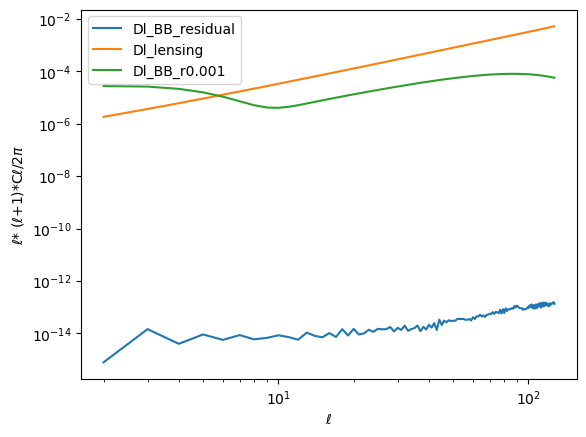

In [45]:
#multipole range 
lmin= 2
lmax= 2*nside-1
ell = np.arange(lmin,lmax+1)


#power spectrum of the total residual 
Cl_BB_residual =hp.anafast(residual_maps_IQU)[2,lmin:lmax+1] #with [2] I select the B mode #closed to bias
Dl_BB_residual = (ell*(ell+1)*Cl_BB_residual)/(2*m.pi)


#Cl theory 
Cl_BB_r1 = _get_Cl_cmb(Alens=0.0, r=1.)[2][lmin:lmax+1]
Cl_BB_r_001 = _get_Cl_cmb(Alens=0.0, r=0.001)[2] [lmin:lmax+1]

#Dl theory
Dl_BB_r001 = (ell*(ell+1)*Cl_BB_r_001)/(2*m.pi)


#lensing
Cl_lens = _get_Cl_cmb(Alens=1.0, r=0.)[2][lmin:lmax+1]
Dl_lens = (ell*(ell+1)*Cl_lens)/(2*m.pi)

#plot power spectra
plt.loglog(ell, Dl_BB_residual, label = "Dl_BB_residual")
plt.loglog(ell, Dl_lens, label = "Dl_lensing")
plt.loglog(ell, Dl_BB_r001, label = "Dl_BB_r0.001")
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell$* ($\ell$+1)*C$\ell$/2$\pi$')
plt.legend()



## 4.Calculate sigma Fisher

In [46]:
Data = Cl_BB_residual + Cl_lens #it is needed by the cosmological likelihood
fsky = 1
F = np.sum((2*ell+1) * fsky / 2*Cl_BB_r1** 2 / Data ** 2) #it is a scalar because I am using comsological likelihood
sigma_r_fisher = np.sqrt(1.0 / F)

In [47]:
i_cmb = M.components.index('CMB')
W_maxL = np.einsum ('cg,gs->cs', AtNA,AtN)[i_cmb,:]
print(W_maxL)


[-0.03041548 -0.01610321 -0.01567061 -0.00607394 -0.002387    0.00446024
  0.00294777  0.02191579  0.00399277  0.04330987  0.09867329  0.12125213
  0.06439264  0.17959845  0.15565562  0.20583402  0.11846318  0.05325374
  0.03602741  0.00161806 -0.02199437 -0.01875036]


In [48]:
#this function takes the gain parameters 21 from the minimization and add the one that is fixed at 1
def G_values_tot(gain_params):
    a, b, c, d, e, f, g, h, i, l, m, n, o, p, q, s, t, u, v, w, z = gain_params
    r= 1
    G = [a, b, c, d, e, f, g, h, i, l, m, n, o, p, q, r, s, t, u, v, w, z]
    return G

gain_params_tot= G_values_tot(result.x[3:]) 

#it gives you the derivative of the gain respect to each gains
def G_diff(gain_params_tot_):
    G_dB = []
    for i,_ in enumerate(result.x[3:]):
        zeros= np.zeros((len(gain_params_tot_),len(gain_params_tot_)))
        zeros[i] = 1
        G_dB.append(zeros)
    return np.array(G_dB)


def zeros(M_dB_):
    M_dB=[]
    zero_column=np.zeros(22)
    for i,_ in enumerate(result.x[:3]):
        if i == 2: 
            M_dB_tot=np.vstack((zero_column,zero_column,M_dB_[i,:,0], zero_column, zero_column, zero_column, 
                                zero_column, zero_column, zero_column, zero_column, zero_column, zero_column, 
                                zero_column, zero_column, zero_column, zero_column, zero_column, zero_column, 
                                zero_column, zero_column, zero_column, zero_column, zero_column, zero_column))   
        else:
            M_dB_tot=np.vstack((zero_column,M_dB_[i,:,0], zero_column, zero_column, zero_column, zero_column, 
                                zero_column, zero_column, zero_column, zero_column, zero_column, zero_column, 
                                zero_column, zero_column, zero_column, zero_column, zero_column, zero_column, 
                                zero_column, zero_column, zero_column, zero_column, zero_column, zero_column))
        M_dB.append(M_dB_tot)
    return np.array(M_dB)



def A_diff_new(params_values):
    spectral_params_values = params_values[:3]
    # gain_params_values = params_values[3:]
    

    #first term
    G_dB=G_diff(gain_params_tot)  #(gain_param,freq,freq)=(21,22,22)
    zeros_matrix=np.zeros((3,22,22))
    G_dB_tot= np.concatenate((zeros_matrix,G_dB), axis=0) #(param, freq, freq)=(24,22,22)
  
    M_ev_val = M_ev(spectral_params_values) #(freq,component)=(22,3)
    # derivatives of G wrt. spectral parameters is zero
    G_dB_M = np.einsum('gif, fc-> gci',  G_dB_tot, M_ev_val) #(param, component, freq)= (24, 3, 22)
   
    

    #second term
    M_dB_ev = M.diff_evaluator(instrument.frequency)
    M_dB_val = np.array(M_dB_ev(spectral_params_values))#(spec_param,freq,component)=(3,22,1)
    M_dB_tot=zeros(M_dB_val)#(component, param, freq)=(3,24,22)
    M_dB_tot=np.array(M_dB_tot)
   
    G = np.diag(np.array(gain_params_tot)) #(freq,freq)=(22,22)
    G_M_dB_val = np.einsum('abc, cd-> bad', M_dB_tot,G) #(param, component, freq)= (24,3,22)
  
 
    A_dB_new= G_dB_M+G_M_dB_val#(params,freq,component)=(24,22,3)
    return A_dB_new


A_dB_maxL= A_diff_new(result.x)

## estimation of the statistical and systematics residuals

In [49]:
def A_diff_diff_new(params_values):
    spectral_params_values = params_values[:3]
    # gain_params_values = params_values[3:]
    
    #first term
    G_dB=G_diff(gain_params_tot)  #(gain_param,freq,freq)=(21,22,22)
    zeros_matrix=np.zeros((3,22,22))
    G_dB_tot= np.concatenate((zeros_matrix,G_dB), axis=0) #(param, freq, freq)=(24,22,22)
    
    M_dB_ev = M.diff_evaluator(instrument.frequency)
    M_dB_val = np.array(M_dB_ev(spectral_params_values))#(spec_param,freq,component)=(3,22,1)
    M_dB_tot=zeros(M_dB_val)#(component, param, freq)=(3,24,22)
    M_dB_tot=np.array(M_dB_tot)

    G_dB_M_dB = np.einsum('abc,dec->aedb', G_dB_tot,M_dB_tot) #(24,24,3,22)
    
    

    # #second term
    M_dB_dB_ev = M.diff_diff_evaluator(instrument.frequency)
    M_dB_dB_val= np.array(M_dB_dB_ev(spectral_params_values))#(3,3)

    M_dB_dB_all = np.zeros((24,24,3,22))
    M_dB_dB_all[0,0,0]= M_dB_dB_val[0,0][:,0]
    M_dB_dB_all[0,1,1]= M_dB_dB_val[0,1][:,0]
    M_dB_dB_all[1,1,0]= M_dB_dB_val[1,0][:,0]
    M_dB_dB_all[1,1,1]= M_dB_dB_val[1,1][:,0]
    M_dB_dB_all[2,2,2]= M_dB_dB_val[2,1][:,0]
    
    
    A_dB_dB_new=  G_dB_M_dB +  G_dB_M_dB +M_dB_dB_all
    print(A_dB_dB_new.shape)

    return A_dB_dB_new

A_dBdB_maxL= A_diff_diff_new(result.x)


(24, 24, 3, 22)


/Users/alicepirotta/miniforge3/envs/gain_env/lib/python3.9/site-packages/autograd/numpy/numpy_wrapper.py:77: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return _np.array(args, *array_args, **array_kwargs)


In [50]:
#W_dB_maxL

a = -np.linalg.inv(np.einsum('cf, fx, xs-> cs',A_maxL.T, invN, A_maxL)) #(3,3)
b = np.einsum('fcg, fx, xs-> cgs',A_dB_maxL.T, invN, A_maxL)+ np.einsum('cf, fx, gsx-> cgs',A_maxL.T, invN, A_dB_maxL)
#(3,24,3)
c = np.linalg.inv(np.einsum('cf, fx, xs-> cs',A_maxL.T, invN, A_maxL))#(3,3)
d = np.einsum('fcg, fx-> cgx',A_dB_maxL.T, invN)#(3,24,22)
e = np.einsum( 'cf, fx-> cx', A_maxL.T, invN)#(3,22)
f = np.einsum ( 'ab, bcd-> acd', a,b)
g = np.einsum ( 'ab, bc-> ac', c,e)


W_dB_maxL = np.einsum('abc, cd-> bad', f,g) + np.einsum('cx, xgf-> gcf', c, d)  #(params_tot,component,freq)=(24,3,22)
print(W_dB_maxL)
W_dB_maxL = W_dB_maxL [:, i_cmb]



[[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]]

 [[-4.03821688e-02 -1.99452608e-02 -1.63158241e-02 ... -4.73953226e-02
   -3.32867001e-02  1.37843531e-04]
  [ 2.86447517e-02  1.49930871e-02  1.42187226e-02 ...  4.24426772e-03
    2.09569379e-02  1.44737967e-02]
  [ 3.96177130e-03  1.84238248e-03  1.24265593e-03 ...  8.62412561e-03
    3.62226726e-03 -1.98810104e-03]]

 [[-1.88250082e-02 -1.56947772e-02 -2.52417624e-02 ...  4.48645592e-03
   -4.28310823e-03 -4.63511351e-03]
  [ 2.86402358e-04  5.01124431e-04  1.01026991e-03 ... -2.41126393e-04
    1.98291560e-04  2.20813634e-04]
  [ 1.71362683e-02  1.25827153e-02  1.89094774e-02 ... -2.96107099e-03
    3.03411306e-03  3.24303054e-03]]

 ...

 [[-5.31378520e-02 -3.303

In [51]:
#W_dB_dB_maxL

h = np.einsum ( 'bacd,be,ef->cdaf', A_dBdB_maxL.T, invN, A_maxL )
i = np.einsum ( 'bac,bd,efd->ceaf', A_dB_maxL.T, invN, A_dB_maxL )
l = np.einsum ( 'ab,bc,defc->deaf', A_maxL.T,invN, A_dBdB_maxL)

p = h+i+i+l
o = np.einsum (  'ab,bc,cd->ad', a,c,e)


H = np.einsum('ab,bcd,de,efg,gh,hi->cfai', a,b,c,b,c,e)
B =  np.einsum ( 'ab,cdea->cdeb',o,p)
C = np.einsum('ab,bcd,de,fg,ghi,if->chae', a,b,e,a,b,c)
D = np.einsum('ab,bcd,de,efg->cfag', a,b,c,d)
E = np.einsum ('ab,cbde,cf->deaf', c,A_dBdB_maxL.T,invN)


W_dB_dB_maxL = - H + B + C + D + D + E
print(W_dB_dB_maxL)
W_dB_dB_maxL =  W_dB_dB_maxL[:, :, i_cmb]

[[[[-9.78034290e-03 -4.32264425e-03 -2.19613739e-03 ...  1.21905558e-01
     1.88226587e-01  1.62061926e-01]
   [ 4.25278098e-01  2.28112586e-01  2.29639735e-01 ... -1.24272489e-02
     2.86884163e-01  2.38156513e-01]
   [ 1.98926964e-02  1.05469653e-02  1.03338718e-02 ... -2.36453950e-02
    -2.23588796e-02 -1.90495527e-02]]

  [[-4.28301893e-05 -2.27730759e-05 -2.24318048e-05 ... -1.06477565e-05
    -4.24618638e-05 -3.28141910e-05]
   [-9.16840020e-04 -4.87489496e-04 -4.80184111e-04 ... -2.27930099e-04
    -9.08955499e-04 -7.02433589e-04]
   [-3.11171683e-05 -1.65451904e-05 -1.62972486e-05 ... -7.73585260e-06
    -3.08495709e-05 -2.38403033e-05]]

  [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
     0.00000000e+00  0.00000000e+00]]

  ...

  [[ 0

In [52]:
if n_stokes == 3:  
    d_spectra = freq_maps
else:  # Only P is provided, add T for map2alm
    d_spectra = np.zeros((n_freqs, 3, freq_maps.shape[2]), dtype=freq_maps.dtype)
    d_spectra[:, 1:] = freq_maps

# Compute cross-spectra
almBs = [hp.map2alm(freq_map, lmax=lmax, iter=10)[2] for freq_map in d_spectra]
Cl_fgs = np.zeros((n_freqs, n_freqs, lmax+1), dtype=freq_maps.dtype)
for f1 in range(n_freqs):
    for f2 in range(n_freqs):
        if f1 > f2:
            Cl_fgs[f1, f2] = Cl_fgs[f2, f1]
        else:
            Cl_fgs[f1, f2] = hp.alm2cl(almBs[f1], almBs[f2], lmax=lmax)

Cl_fgs = Cl_fgs[..., lmin:] / fsky

In [53]:

V_maxL = np.einsum('ij,ij...->...', sigma_params_square, W_dB_dB_maxL)

# Check dimentions
assert ((n_freqs,) == W_maxL.shape == W_dB_maxL.shape[1:]== W_dB_dB_maxL.shape[2:] == V_maxL.shape)
assert (len(result.x) == W_dB_maxL.shape[0] == W_dB_dB_maxL.shape[0] == W_dB_dB_maxL.shape[1])

# elementary quantities defined in Stompor, Errard, Poletti (2016)
Cl_xF = {}
Cl_xF['yy'] = _utmv(W_maxL, Cl_fgs.T, W_maxL)  # (ell,)= (191)
Cl_xF['YY'] = _mmm(W_dB_maxL, Cl_fgs.T, W_dB_maxL.T)  # (ell, param, param)=(191,24,24)
Cl_xF['yz'] = _utmv(W_maxL, Cl_fgs.T, V_maxL )  # (ell,)
Cl_xF['Yy'] = _mmv(W_dB_maxL, Cl_fgs.T, W_maxL)  # (ell, param)
Cl_xF['Yz'] = _mmv(W_dB_maxL, Cl_fgs.T, V_maxL)  # (ell, param)

print(Cl_xF['yz'] )

Cl_noise = _get_Cl_noise(instrument, A_maxL, lmax)[ i_cmb,  i_cmb, lmin:]

# bias and statistical foregrounds residuals
noise = Cl_noise
bias = Cl_xF['yy'] + 2 * Cl_xF['yz'] #should be 0 
stat = np.einsum('ij, lij -> l', sigma_params_square, Cl_xF['YY'])  
var = stat**2 + 2 * np.einsum('li, ij, lj -> l', Cl_xF['Yy'], sigma_params_square, Cl_xF['Yy'])
# noise_stat= noise + stat

#control that Cl_BB_residual = noise + stat


[ 7.68410732e-05  6.56438712e-04  8.42748501e-05  1.61107645e-04
  6.04696024e-05  8.04937689e-05  3.89282284e-05  3.51227462e-05
  3.40275643e-05  2.04727953e-05  1.29774756e-05  1.88411539e-05
  1.43803317e-05  9.23388933e-06  1.07919174e-05  7.30415701e-06
  1.22873929e-05  5.46652078e-06  9.26729700e-06  4.99360799e-06
  5.27679236e-06  6.28095493e-06  4.58357906e-06  5.77825504e-06
  4.61281194e-06  4.49428342e-06  4.18811545e-06  3.20976594e-06
  3.22571101e-06  2.91999127e-06  3.15624454e-06  2.10222741e-06
  1.64940360e-06  1.61772130e-06  1.93629418e-06  7.14709980e-07
  8.44838626e-07  1.32561557e-06  8.88373659e-07  1.32260748e-06
  1.09431293e-06  7.06699641e-07  9.98260937e-07  6.84962149e-07
  9.09809819e-07  7.19975912e-07  1.11749344e-06  7.20337874e-07
  8.06434732e-07  3.54682051e-07  1.01822950e-06  4.88379454e-07
  1.04838720e-06  5.83298667e-07  7.67611264e-07  3.68262751e-07
  3.78671595e-07  2.27572723e-07  5.11710420e-07  3.01012996e-07
  3.30912267e-07  3.61437

(2, 127)

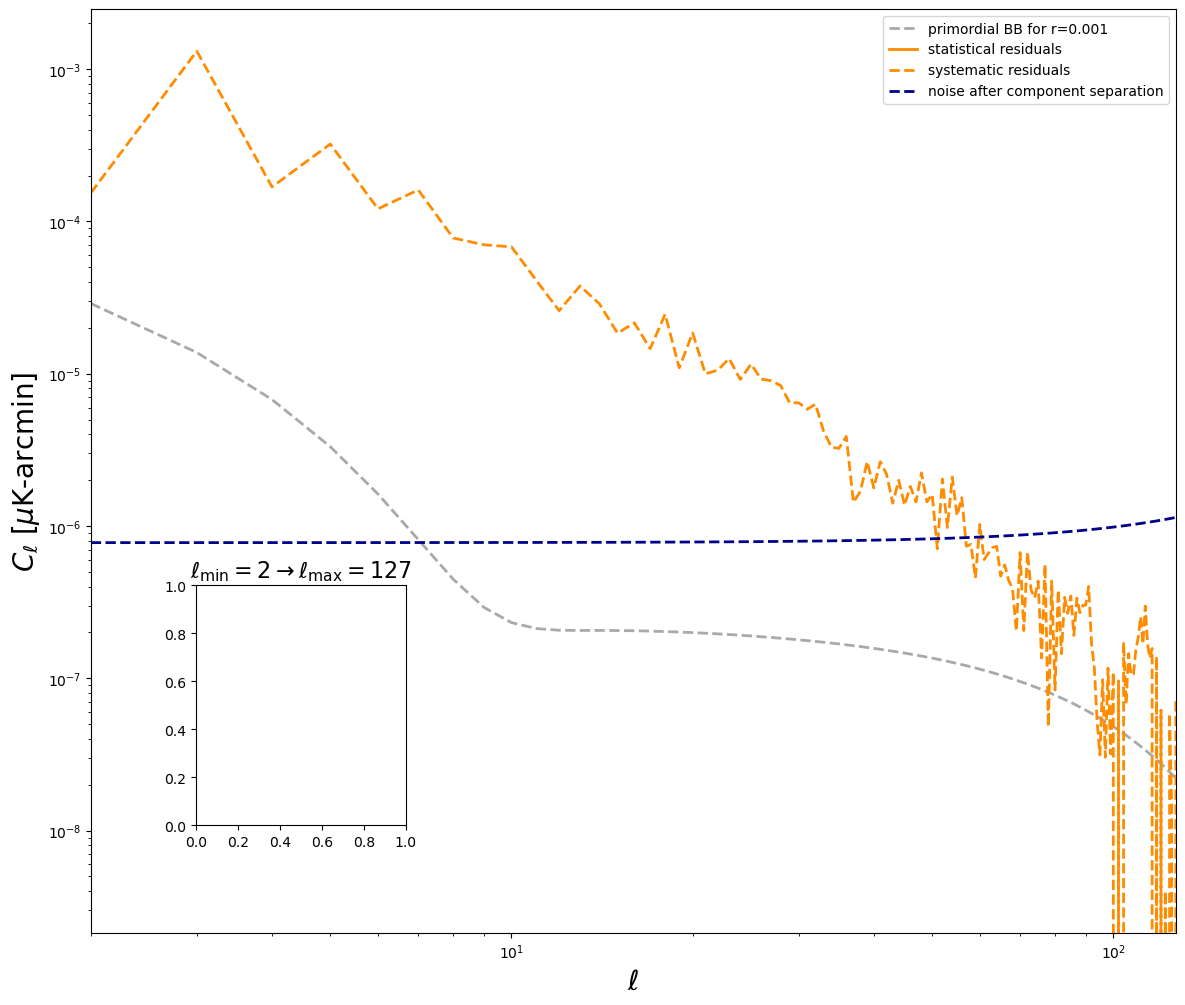

In [54]:
lmin= 2
lmax= 127
ell = np.arange(lmin, lmax+1)


Cl_fid = {}
Cl_fid['BB'] = _get_Cl_cmb(Alens=0.1, r=0.001)[2][lmin:lmax+1]
Cl_fid['BuBu'] = _get_Cl_cmb(Alens=0.0, r=1.0)[2][lmin:lmax+1]
Cl_fid['BlBl'] = _get_Cl_cmb(Alens=1.0, r=0.0)[2][lmin:lmax+1]



fig = pl.figure( figsize=(14,12), facecolor='w', edgecolor='k' )
ax = pl.gca()
left, bottom, width, height = [0.2, 0.2, 0.15, 0.2]
ax0 = fig.add_axes([left, bottom, width, height])
ax0.set_title(r'$\ell_{\min}=$'+str(lmin)+\
    r'$ \rightarrow \ell_{\max}=$'+str(lmax), fontsize=16)

# ax.loglog(ell, Cl_BB_r_001, color='DarkGray', linestyle='-', label='BB tot', linewidth=2.0)
ax.loglog(ell, Cl_BB_r_001 , color='DarkGray', linestyle='--', label='primordial BB for r='+str(0.001), linewidth=2.0)
ax.loglog(ell, stat, 'DarkOrange', label='statistical residuals', linewidth=2.0)
ax.loglog(ell, bias, 'DarkOrange', linestyle='--', label='systematic residuals', linewidth=2.0)
ax.loglog(ell, noise, 'DarkBlue', linestyle='--', label='noise after component separation', linewidth=2.0)
# ax.loglog(ell, Cl_BB_residual, 'DarkGreen', linestyle='--', label='residual', linewidth=1.0)
ax.legend()
ax.set_xlabel('$\ell$', fontsize=20)
ax.set_ylabel('$C_\ell$ [$\mu$K-arcmin]', fontsize=20)
ax.set_xlim(lmin,lmax)

In [55]:
# lmin= 2
# lmax= 192
# ell = np.arange(lmin,lmax)

# plt.loglog(ell, Cl_BB_r_001, label = "Cl_BB_r0.001") 
# plt.loglog(ell, Cl_BB_residual, label = "Cl_BB_residual")



# lmin= 2
# lmax= 193
# ell = np.arange(lmin,lmax)

# plt.loglog(ell, noise , label = "noise ")
# plt.loglog(ell, bias , label = "bias")
# plt.loglog(ell, stat , label = "stat")
# plt.loglog(ell,var, label = "var")
# #plt.loglog(ell,noise_stat, label = "noise+stat")

# plt.xlabel(r'$\ell$')
# plt.ylabel(r'Cl')
# plt.legend()